In [1]:
#consider using svist4get api for adding open chromatin peak tracks: https://bitbucket.org/artegorov/svist4get/src/eeb5151f49c31fa887dbfc168320c63d66a17334/docs/API.md
#actually use https://github.com/deeptools/pyGenomeTracks as can install with conda
#then import each track as vector image like here: https://stackoverflow.com/questions/31452451/importing-an-svg-file-into-a-matplotlib-figure using svgutils
#integrate it with matplotlib like mentioned here: https://github.com/deeptools/pyGenomeTracks/issues/20
#the bigwig files I used were from potter et al 2018 NaOH treatment https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE116287 called GSE116287_Roots_NaOH_Merged.bw and GSE116287_Shoots_NaOH_Merged.bw
#had to install "conda install -c conda-forge tqdm" too

##NOTE - if using genbank files from Benchling, first add custom fields on the metadata page with the start and end index (eg. start_index 6015558)
##also ensure the name of the genebank file (and sequence id) include the AGI locus name enclosed in parentheses(eg. "(AT4G24020)")
##This is so the chromosome number can be extracted
##This is to ensure the start and end chromosome positions open chromatin data
#make sure when exporting the .gb file from Benchling that you do not tick "Convert Non-Standard Annotation Types"
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
#latex style rendering so can make parts of text bold
from matplotlib import rc
#import matplotlib as mpl
from Bio import SeqIO
from Bio.SeqFeature import FeatureLocation
import numpy as np
#allows custom colours
from dna_features_viewer import BiopythonTranslator
import pandas as pd
from itertools import cycle
import re
import pandas as pd
#allow converting from RGB to CMYK
#import cv2
from PIL import Image
# from PIL import Image
# from io import BytesIO
import pygenometracks.tracks as pygtk

###note  - use conda env gene_feature_plot


In [2]:
#create a class specifying feature colours
#make feature_list and colour_dict so that each feature name and colour is only added once to legend if more than one share the same name

feature_list = []
colour_dict = {}
class MyCustomTranslator(BiopythonTranslator):
    """Custom translator iplementing the following theme:
    -Colour promoter in pale green
    -colour exons in dark grey
    -colour introns in light grey
    -colour TFs from colour palette"""

    #import colour blind palette
    #colour palette from mkweb.bcgsc.ca/colorblind/palettes.mhtml
    # df = pd.read_csv("colourblind_palette.csv", header=0)
    # #convert to floats
    # floats=df.divide(255)
    # #make sets of each row to get the red, green blue colours
    # CB_colour_palette = floats.apply(tuple, axis = 1)
    # #make into df
    # df = CB_colour_palette.to_frame()
    # #save file
    # df.to_csv('../../data/TRAMP/colour_list')
    
    # #turn into a list of colour sets
    # list_colours = list(CB_colour_palette)
    # colour_list = list_colours
    #colour_list = ['#88CCEE', '#44AA99', '#117733', '#332288', '#DDCC77', '#999933','#CC6677', '#882255', '#AA4499', '#DDDDDD']
    colour_list = ['#2271B2',
    '#3DB7E9',
    '#F748A5',    
    '#d55e00',
    '#e69f00',
    '#f0e442',
    '#000000',]
    #make colour iterator
    colour_iterator=cycle(colour_list)
    #change colour cycle
    #mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=list_colours)
    #count = -1
    #set colour count


    def compute_feature_color(self, feature):
        """set colour of each feature"""      

        if feature.type == "promoter":
            return "#F5F5F5"
        elif feature.type == "exon":
            return "darkgrey"
            #return (169,169,169)
        elif feature.type == "intron":
            return "lightgrey"  
            #return (211,211,211)
        elif feature.type == "5'UTR":
            return "lightgrey"
        elif feature.type == "start_codon":
            return "black"
        elif feature.type == "TFBS":
            if feature.qualifiers.get("label")[0] in colour_dict.keys():
                col = colour_dict[feature.qualifiers.get("label")[0]]
            else:
                col = next(self.colour_iterator)
                colour_dict[feature.qualifiers.get("label")[0]] = col
                        
            return col
        else:
            return "gold"

    def compute_feature_box_linewidth(self, feature):
        """change shape of features"""
        return 0

    def compute_feature_linewidth(self, feature):
        """change linewidth of feature's arrow/rectangle"""
        return 1

    def compute_feature_open_left(self, feature):
        """set to true if feature does not end on the left"""
        return False

    def compute_feature_open_right(self, feature):
        """set to true if feature does not end on the right"""
        return False

    def compute_feature_label(self, feature):
        """Remove most feature labels"""
        if feature.type == 'start_codon':
            return "ATG"        
        else:
            pass

        #return super().compute_feature_label(feature)
        

    def compute_feature_fontdict(self, feature):
        """change font to arial, size to 10"""
        return dict(family='sans-serif',size=8)
        #return dict([('family','sans-serif'),('sans-serif','Arial'),('size',10)])

    #make feature_list so that each feature name is only added once if more than one share the same name
    #feature_list = []
    def compute_feature_legend_text(self, feature):
        """add legend if feature label has not been added to legend already"""
        if feature.type=='promoter':
            pass
        elif feature.type=='exon':
            pass
        elif feature.type=='intron':
            pass
        elif feature.type=="5'UTR":
            pass
        # elif feature.qualifiers.get("label")[0] in self.feature_list:
        #     pass
        elif feature.qualifiers.get("label")[0] in feature_list:
            pass
        else:
            
            feature_list.append(feature.qualifiers.get("label")[0])
                 
            #feature_list.append(feature.qualifiers.get("label")[0])
            return feature.qualifiers.get("label")[0]     


    def compute_filtered_features(self, features):
        """Do not display features the following features"""
        return [
            feature for feature in features
            if (feature.type != "TRAMP_probe")
            and (feature.type != "none")
            and (feature.type != "DHS")
            and (feature.type != "misc_feature")
            and (feature.type != "primer")
            and (feature.type != "gene")
            and (feature.type != "mRNA")
            and (feature.type != "CDS")
            and (feature.type != "source")
            and (feature.type != "misc_RNA")
            and (feature.qualifiers.get("label")[0] != "ARID5_ARID6"
            and (feature.qualifiers.get("label")[0] != "ARDI5_ARID6")
            and ('Translation' not in feature.qualifiers.get("label")[0]))
            ]
        

In [3]:
def preprocess_record(seqrecord):
    """Preprocess the biopython record before feeding it into the translator."""
    #get length of the whole sequence
    #seq_length = len(seqrecord.seq)
    # #print(f'{seqrecord.id} + {seq_length}')
    # #change seqrecord locations
    # #if start location is greater than TSS position then the new location is the length of the whole sequence minus the original position
    # def convert_location(location, TSS_position, seq_length):
    #     """convert locations to be relative to TSS position (or another locaton if you choose)"""
    #     if location > TSS_position:
    #         new_location = seq_length - location
    #     elif location < TSS_position:
    #         new_location = -(TSS_position-location)
    #     elif location == TSS_position:
    #         new_location = 0
    #     return new_location
    # print(seqrecord)
    #Ensure that genbank files are reverse complemented so that plots can be aligned to the right in figure
    new_seqrecord = seqrecord.reverse_complement(id=seqrecord.id +"_rc")
    
    for feature in new_seqrecord.features:
        #change strand to None so that features are rectangular
        feature.location.strand = None
             
        if feature.type == 'TFBS':
            #print(feature)
            #change sigil to box
            feature.qualifiers["sigil"] = 'OCTAGON'
            #increase width of TFBS so colour is more visible
            start = feature.location.start
            end = feature.location.end
            #find middle of TFBS
            middle = (end-start)//2 #floor division creating an integar
            
            new_start = start-20+middle
            new_end = end-middle+20
            feature.location = FeatureLocation(new_start,new_end)
            #change name of some TFBSs
            if feature.qualifiers.get("label")[0] == 'ANR1_AGL16':
                feature.qualifiers.get("label")[0] = 'ANR1*'
            elif feature.qualifiers.get("label")[0] == 'ANAC032_NAC002':
                feature.qualifiers.get("label")[0] = 'ANAC032*'
            elif feature.qualifiers.get("label")[0] == 'ANAC032':
                feature.qualifiers.get("label")[0] = 'ANAC032*'
            elif feature.qualifiers.get("label")[0] == 'ARF18/9_ARF2':
                feature.qualifiers.get("label")[0] = 'ARF9/18*'
            elif feature.qualifiers.get("label")[0] == 'ARF9/18':
                feature.qualifiers.get("label")[0] = 'ARF9/18*'
            elif feature.qualifiers.get("label")[0] == 'NLP7':
                feature.qualifiers.get("label")[0] = 'NLP6/7'
                
         

            #if feature was experimentally validated, add qualifier
            
    return new_seqrecord



In [4]:
def gb_file_to_seqrecord(promoter_name):
    """load genbankfile into a seqrecord"""
    #file location
    gb_file=f"../../data/TRAMP/{promoter_name}.gb"
    record = SeqIO.read(gb_file, 'genbank')
    #preprocess record
    modified_seqrecord = preprocess_record(record)
    return modified_seqrecord

In [5]:
def RGB2CMYK(image_file_location, image_file_extension):
    """convert image from RGB to CMYK colours"""
    # Import image
    image = Image.open(image_file_location+image_file_extension)
    print(image.mode)
    if image.mode == 'RGBA':
        print('converting_image')
        cmyk_image = image.convert('CMYK')
        cmyk_image.save(image_file_location+'_CMYK'+image_file_extension)
    #close image
    image.close()
    # img = plt.imread(image_file_location+image_file_extension)
    # #print(image_file_location+image_file_extension)
    # # Create float
    # bgr = img.astype(float)/255.

    # # Extract channels
    # with np.errstate(invalid='ignore', divide='ignore'):
    #     K = 1 - np.max(bgr, axis=2)
    #     C = (1-bgr[...,2] - K)/(1-K)
    #     M = (1-bgr[...,1] - K)/(1-K)
    #     Y = (1-bgr[...,0] - K)/(1-K)

    # # Convert the input BGR image to CMYK colorspace
    # CMYK = (np.dstack((C,M,Y,K)) * 255).astype(np.uint8)
    # cv2.imwrite(image_file_location+'_CMYK'+image_file_extension, CMYK)

    # # Split CMYK channels
    # Y, M, C, K = cv2.split(CMYK)

    # np.isfinite(C).all()
    # np.isfinite(M).all()
    # np.isfinite(K).all()
    # np.isfinite(Y).all()

    # # Save channels
    # cv2.imwrite('C:/path/to/C.jpg', C)
    # cv2.imwrite('C:/path/to/M.jpg', M)
    # cv2.imwrite('C:/path/to/Y.jpg', Y)
    # cv2.imwrite('C:/path/to/K.jpg', K)


In [6]:
# #create a class specifying feature colours
# #make feature_list and colour_dict so that each feature name and colour is only added once to legend if more than one share the same name

# feature_list = []
# colour_dict = {}
# class MyCustomTranslator(BiopythonTranslator):
#     """Custom translator iplementing the following theme:
#     -Colour promoter in pale green
#     -colour exons in dark grey
#     -colour introns in light grey
#     -colour TFs from colour palette"""

#     #import colour blind palette
#     #colour palette from mkweb.bcgsc.ca/colorblind/palettes.mhtml
#     # df = pd.read_csv("colourblind_palette.csv", header=0)
#     # #convert to floats
#     # floats=df.divide(255)
#     # #make sets of each row to get the red, green blue colours
#     # CB_colour_palette = floats.apply(tuple, axis = 1)
#     # #make into df
#     # df = CB_colour_palette.to_frame()
#     # #save file
#     # df.to_csv('../../data/TRAMP/colour_list')
    
#     # #turn into a list of colour sets
#     # list_colours = list(CB_colour_palette)
#     # colour_list = list_colours
#     #colour_list = ['#88CCEE', '#44AA99', '#117733', '#332288', '#DDCC77', '#999933','#CC6677', '#882255', '#AA4499', '#DDDDDD']
#     colour_list = ['#2271B2',
#     '#3DB7E9',
#     '#F748A5',    
#     '#d55e00',
#     '#e69f00',
#     '#f0e442',
#     '#000000',]
#     #make colour iterator
#     colour_iterator=cycle(colour_list)
#     #change colour cycle
#     #mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=list_colours)
#     #count = -1
#     #set colour count


#     def compute_feature_color(self, feature):
#         """set colour of each feature"""      

#         if feature.type == "promoter":
#             return "#359B73"
#         elif feature.type == "exon":
#             return "darkgrey"
#             #return (169,169,169)
#         elif feature.type == "intron":
#             return "lightgrey"  
#             #return (211,211,211)
#         elif feature.type == "5'UTR":
#             return "lightgrey"
#         elif feature.type == "TFBS":
#             if feature.qualifiers.get("label")[0] in colour_dict.keys():
#                 col = colour_dict[feature.qualifiers.get("label")[0]]
#             else:
#                 col = next(self.colour_iterator)
#                 colour_dict[feature.qualifiers.get("label")[0]] = col
                        
#             return col
#         else:
#             return "gold"

#     def compute_feature_box_linewidth(self, feature):
#         """change shape of features"""
#         return 0

#     def compute_feature_label(self, feature):
#         """Remove feature labels"""
#         #return super().compute_feature_label(feature)
        

#     def compute_feature_fontdict(self, feature):
#         """change font to arial, size to 10"""
#         return dict(family='sans-serif',size=10)
#         #return dict([('family','sans-serif'),('sans-serif','Arial'),('size',10)])

#     #make feature_list so that each feature name is only added once if more than one share the same name
#     #feature_list = []
#     def compute_feature_legend_text(self, feature):
#         """add legend if feature label has not been added to legend already"""
#         if feature.type=='promoter':
#             pass
#         elif feature.type=='exon':
#             pass
#         elif feature.type=='intron':
#             pass
#         elif feature.type=="5'UTR":
#             pass
#         # elif feature.qualifiers.get("label")[0] in self.feature_list:
#         #     pass
#         elif feature.qualifiers.get("label")[0] in feature_list:
#             pass
#         else:        

#             feature_list.append(feature.qualifiers.get("label")[0])
                 
#             #feature_list.append(feature.qualifiers.get("label")[0])
#             return feature.qualifiers.get("label")[0]     


#     def compute_filtered_features(self, features):
#         """Do not display features the following features"""
#         return [
#             feature for feature in features
#             if (feature.type != "TRAMP_probe")
#             and (feature.type != "none")
#             and (feature.type != "DHS")
#             and (feature.type != "misc_feature")
#             and (feature.type != "primer")
#             and (feature.type != "gene")
#             and (feature.qualifiers.get("label")[0] != "ARID5_ARID6"
#             and (feature.qualifiers.get("label")[0] != "ARDI5_ARID6"))
#             ]
        

In [7]:
# def genometrack_plot(file_location):
#     """make pyGenomeTracks plot"""
#     fig, axs = plt.subplots(2,1,sharex='col')
#     region = '1',3000,6000
#     chrom_region,start_region,end_region = region
#     ax = axs[1]

#     track_config = dict(
#         file=file_location)

In [8]:
# def make_plot2(dictionary_of_records_seqrecords,dictionary_of_records_promoternames):
#     #length of dictionary
#     length_dict = len(dictionary_of_records_promoternames)  
#     height = length_dict//2
#     fig, axs = plt.subplots(length_dict,1,sharex='none',figsize=(10,height*2))
#     def pygenometracks(chrom_region,start_region,end_region,axis):
#                 """make pygenome track for bigwig files"""        
#                 file_location_roots="../../data/ATAC-seq/potter2018/GSE116287_Roots_NaOH_Merged.bw"
#                 file_location_shoots="../../data/ATAC-seq/potter2018/GSE116287_Shoots_NaOH_Merged.bw"
#                 track_config_roots = dict(file=file_location_roots,overlay_previous = 'share-y',color='brown')
#                 track_config_shoots = dict(file=file_location_shoots,overlay_previous = 'share-y',alpha = 0.5)#alpha is transparency
#                 tk_roots = pygtk.BigWigTrack(track_config_roots)
#                 tk_shoots = pygtk.BigWigTrack(track_config_shoots)
#                 tk_roots.plot(axis,chrom_region,start_region,end_region,)
#                 tk_shoots.plot(axis,chrom_region,start_region,end_region,)
#             #make graphic records of genes and TFBSs
#     for k,v in dictionary_of_records_seqrecords.items():
#         #take last character of string, double it as twice as many sequence tracks to include open chromatin atacseq data
#         last = int(k[-1])
#         #get promoter name
#         prom_name = dictionary_of_records_promoternames[k]
#         #split on dashes
#         #short_prom_name = prom_name.split('-')[0].upper()
#        #make_graphic_record(v,short_prom_name,axsRight[last-2]
#         #print(v.id)
#         #add atacseq track
#         #first get chromosome number from sequence ID
#         AGI = v.id[v.id.find('(')+1:v.id.find(')')]
#         chrom_region = AGI[2]
#         #then get start and stop region
#         #open genbank file, read third line containing keywords
#         gb_file=f"../../data/TRAMP/{prom_name}.gb"
#         with open(gb_file, "r") as f:
#             all_lines = f.readlines()
#             start_region = int(re.findall(r"start_index:(\d+)",all_lines)[0])
#             end_region = int(re.findall(r"end_index:(\d+)",all_lines)[0])

#         #keywords = re.findall(r"KEYWORDS.*"   
        
#         print("start="+str(start_region)+"end="+str(end_region))        
#         pygenometracks(chrom_region,start_region,end_region,axs[last-1])
#         #add titles
#         short_prom_name = prom_name.split('-')[0].upper()
#         axs[last-1].set_title(short_prom_name)
#         #change xvalues of open chromatin track
#         region_length = end_region-start_region
#         ax1Ticks = axs[last-1].get_xticks()   
#         #ax2Ticks = ax1Ticks
#         def tick_function(X,start_region):
#             V = X-start_region
#             return ["%.3f" % z for z in V]
#         #axs[last-1].set_xticks(ax2Ticks)
#         #ax2.set_xbound(ax1.get_xbound())
#         axs[last-1].set_xticklabels(tick_function(ax1Ticks,start_region))

#         #plt.xticks(np.arange(end_region-start_region),np.arange(end_region-start_region))
#     #make x axes start at 1
    
#     fig.tight_layout()
#     # chrom_region,start_region,end_region = region
#     # ax = axs[1]
#     # file_location_roots="../../data/ATAC-seq/potter2018/GSE116287_Roots_NaOH_Merged.bw"
#     # file_location_shoots="../../data/ATAC-seq/potter2018/GSE116287_Shoots_NaOH_Merged.bw"
#     # track_config_roots = dict(file=file_location_roots,overlay_previous = 'share-y',color='brown')
#     # track_config_shoots = dict(file=file_location_shoots,overlay_previous = 'share-y',alpha = 0.5)#alpha is transparency
#     # tk_roots = pygtk.BigWigTrack(track_config_roots)
#     # tk_shoots = pygtk.BigWigTrack(track_config_shoots)
#     # tk_roots.plot(axs[0],chrom_region,start_region,end_region,)
#     # tk_shoots.plot(axs[0],chrom_region,start_region,end_region,)


In [87]:
def make_plot(dictionary_of_records_seqrecords,dictionary_of_records_promoternames,atacseq=True):
    def make_graphic_record(seqrecord, promoter_name, ax,title=True):
        """make a graphic record object"""
        #display figure    
        graphic_record = MyCustomTranslator().translate_record(seqrecord)
        #change height to 0 so TFBS can overlap the promoter
        graphic_record.feature_level_height = 0
        #graphic_record = BiopythonTranslator().translate_record(gb_file)
        graphic_record.plot(ax=ax, with_ruler=True,annotate_inline=True)#,figure_width=10, #strand_in_label_threshold=4,annotate inline=True so that labels are within the feature
        
        #add title of promoter
        if title is True:
            ax.title.set_text(promoter_name)
        #return graphic_record
    #set plot parameters
    rcParams['xtick.major.width'] = 2
    rcParams['ytick.major.width'] = 2
    #rcParams['axes.linewidth'] = 2
    #rcParams['lines.linewidth'] = 2
    #remove top and right lines
    # rcParams['axes.spines.top'] = False
    # rcParams['axes.spines.right'] = False
    #font size
    rcParams['font.size'] = 11


    #length of dictionary
    length_dict = len(dictionary_of_records_promoternames)
    #
    #if including atacseq track, include more subfigures
    if atacseq is True:
        #make plot
        height = length_dict//2+length_dict-1 #add length_dict-1 to include empty grids for spacing between pairs
        ### NEED TO MAKE INTO A GRID LIKE HERE: https://stackoverflow.com/questions/51717199/how-to-adjust-space-between-every-second-row-of-subplots-in-matplotlib

        


        fig = plt.figure(constrained_layout=False,figsize=(12,height-5))
        #make subfigures
        #subfigs = fig.subfigures(1,2, wspace=0.0, width_ratios=[1,5])
        #left legend 
        #axsLeft=subfigs[0].subplots(1,1)
        #remove axis
        #axsLeft.axis('off')
        # #right figures
        #create gridspec so that open chromatin is paired with promoter
        n = length_dict # number of double-rows
        m = 2 # number of columns

        t = 0.9 # 1-t == top space 
        b = 0.1 # bottom space      (both in figure coordinates)

        msp = -0.4 # minor spacing
        sp = 0.5  # major spacing
        offs=(1+msp)*(t-b)/(2*n+n*msp+(n-1)*sp) # grid offset
        hspace = sp+msp+1 #height space per grid

        gso = GridSpec(n,m, bottom=b+offs, top=t, hspace=hspace,width_ratios=[2,10])
        gse = GridSpec(n,m, bottom=b, top=t-offs, hspace=hspace,width_ratios=[2,10])

        #fig = plt.figure()

        grid = []
        for i in range(n*m):
            grid.append(fig.add_subplot(gso[i]))
            grid.append(fig.add_subplot(gse[i]))
        

        
        #print(grid)
        #print(len(grid))
        #split plots into two lists - one for left column and one for the right
        #turn off axes for the plots on the left
        axsRight = []
        axsLeft = []
        count=0
        for number in np.arange(len(grid)):
            if count == 0:
                axsLeft += [grid[number]]
                grid[number].axis('off')
                count +=1
            elif count == 1:
                axsLeft += [grid[number]]
                count +=1
                grid[number].axis('off')
            elif count == 2:
                axsRight += [grid[number]]
                count +=1
            elif count ==3:
                axsRight += [grid[number]]
                count = 0

        #make legend span two plots 
        axsLeft[0].set_position(gso[0:3].get_position(fig))
        #axsLeft[1].set_position(gso[0:3].get_position(fig)
   
                
      
                
        #move plots closeer to each other
        # for i in range(0,len(axsRight),2):
        #     axsRight[i] = plt.subplot()
        #print(axsRight)
        



        # num_rows = length_dict*2
        # num_cols = 1
        # row_height = 6
        # space_height = 2
        # num_sep_rows = lambda x: int((x-1)/2)
        # grid = (row_height*num_rows + space_height*num_sep_rows(num_rows), num_cols)
        # #axsRight = subfigs[1].subplots(num_rows,1,sharex=False)
        # #axsRight = subfigs[1]
        # axsRight = []

        # for ind_row in range(num_rows):
        #     for ind_col in range(num_cols):
        #         grid_row = row_height*ind_row + space_height*num_sep_rows(ind_row+1)
        #         grid_col = ind_col

        # axsRight += [plt.subplot2grid(grid, (grid_row, grid_col), rowspan=row_height)]

        
        def pygenometracks(chrom_region,start_region,end_region,axis):
            """make pygenome track for bigwig files"""        
            file_location_roots="../../data/ATAC-seq/potter2018/GSE116287_Roots_NaOH_Merged.bw"
            file_location_shoots="../../data/ATAC-seq/potter2018/GSE116287_Shoots_NaOH_Merged.bw"
            track_config_roots = dict(file=file_location_roots,overlay_previous = 'share-y',color='brown',min_value=0, max_value=30)
            track_config_shoots = dict(file=file_location_shoots,overlay_previous = 'share-y',alpha = 0.5,min_value=0, max_value=30)#alpha is transparency
            tk_roots = pygtk.BigWigTrack(track_config_roots)
            tk_shoots = pygtk.BigWigTrack(track_config_shoots)
            tk_roots.plot(axis,chrom_region,start_region,end_region,)
            tk_shoots.plot(axis,chrom_region,start_region,end_region,)
        #make graphic records of genes and TFBSs
        for k,v in dictionary_of_records_seqrecords.items():
            #take last character of string, double it as twice as many sequence tracks to include open chromatin atacseq data
            last = int(k[-1])*2+1
            last_chromatin = int(k[-1])*2
            #get promoter name
            prom_name = dictionary_of_records_promoternames[k]
            #split on dashes
            short_prom_name = prom_name.split('-')[0].upper()
            make_graphic_record(v,short_prom_name,axsRight[last-2],title=False)

            #print(v.id)
            #add atacseq track
            #first get chromosome number from sequence ID
            chrom_region = re.findall(r"chromosome:TAIR10:(\d)",v.id)[0]
            #chrom_region = v.id[v.id.find('TAIR10:')+1:v.id.find(':')]
            #print(v)
            #print(chrom_region)
            #chrom_region = AGI[2]
            #then get start and stop region
            #open genbank file, read third line containing keywords
            gb_file=f"../../data/TRAMP/{prom_name}.gb"
            with open(gb_file, "r") as f:
                all_lines = f.readlines()
                for line in all_lines:
                    if re.match(r'KEYWORDS', line):
                        keywords = line                
            start_region = int(re.findall(r"start_index:(\d+)",keywords)[0])
            end_region = int(re.findall(r"end_index:(\d+)",keywords)[0])
            #print(start_region)  
            pygenometracks(chrom_region,start_region,end_region,axsRight[last_chromatin-2])
            #set xlim
            offset_length = 4550-(end_region-start_region)
            axsRight[last_chromatin-2].set_xlim(start_region-offset_length,end_region)
            #get x and y lim
            #axsRight[last_chromatin-2].set_title(short_prom_name,y=0.5, ) #put title to left of axis
            ##setlocation of the title         
            #first transform offset_length to between 0 and 1 for axes location, and offset a little to the left
            trans = (offset_length-25)/4550

            
            axsRight[last_chromatin-2].text(x=trans, y=0.125, s=short_prom_name, weight="extra bold", fontsize=12,transform=axsRight[last-2].transAxes, ha='right')#transform=axsRight[last_chromatin-2].transAxes

            
            #axsRight[last_chromatin-2].invert_xaxis()
            #change xvalues of open chromatin track      
            #first get x and y values
            #line = axsRight[last_chromatin-2].get_lines()
            #xd = line.get_xdata()
            #yd = line.get_ydata()
            #print(line)
            #ax1Ticks = axsRight[last_chromatin-2].get_xticks()   
           # ax2Ticks = ax1Ticks.copy()
            # def tick_function(X,start_region):
            #     V = X-start_region
            #     return ["%.3f" % z for z in V]

            #
            #axs[last-1].set_xticks(ax2Ticks)
            #ax2.set_xbound(ax1.get_xbound())
            #axsRight[last_chromatin-2].set_xticklabels(tick_function(ax2Ticks,start_region))
            #axsRight[last_chromatin-2].set_xscale('function', functions=(forward_function,inverse_function))
            #make x labels integars
            

        colour_dict_sorted = {k: v for k,v in sorted(colour_dict.items(), key=lambda item: item[0])}
        #print(colour_dict_sorted)
        handles = []
        for TFBS,colour in colour_dict_sorted.items():
            addition = mpatches.Patch(color=colour, label=TFBS)
            #append to handles list
            handles.append(addition)
        #use latex style rendering to allow parts to be bold
        rc('text', usetex=True)

        #handles = sorted(handles)

        #create legend and align left
        first_legend=axsLeft[0].legend(handles=handles, loc='upper right', title=r"\textbf{Transcription factor binding site}", title_fontsize='14',ncol=2)
        # # Add the legend manually to the current Axes.
        # axsLeft[0] = plt.gca().add_artist(first_legend)
        # # Create another legend for the second line.
        # axsLeft[0].legend(handles=handles_chromatin, loc='lower right', title=r"\textbf{Open chromatin peaks}", title_fontsize='14',ncol=2)
        # #turn off latex rendering of text
        rc('text', usetex=False)
       
        #change x_lim to flip x axis
        for n in np.arange(length_dict):
            last = n*2+1
            
            axsRight[last-2].set_xlim(4550,0)
            
            #change font colour of x axis text
            axsRight[last-2].tick_params(axis='x', colors='black')
            #change width of line
            # for axis in ['bottom','right']:
            #     ax.spines[axis].set_linewidth(5)

            x_ticks = np.arange(176, 4550, 500) #start stop and step
            axsRight[last-2].set_xticks(x_ticks)
            fig.canvas.draw()
            # if axsRight[last-2] == axsRight[length_dict*2-1]:
            #     pass
            # else:
            #     #remove xticks
            #     #axsRight[last-2].xaxis.set_ticks_position('none')
            #     #remove axes
            #     ax.axis('off')
                
        #remove all axes
        for ax in axsRight:   

            if ax == axsRight[length_dict*2-1]:
                pass
            else:
                #ax.xaxis.set_ticks_position('none')
                ax.axis('off')

        
        labels = [item._text for item in axsRight[length_dict*2-1].get_xticklabels()]
        #labels: ['176', '676', '1,176', '1,676', '2,176', '2,676', '3,176', '3,676', '4,176']
        new_labels = []
        for label in labels:
            #remove non-numberic character from string
            label = re.sub("[^0-9]","",label)                
            label = 1176-int(label)
            if label == 0:
                label = f'{0} (TSS)'

            new_labels.append(label)
        axsRight[length_dict*2-1].set_xticklabels(new_labels)
        #set x axis to be a little closer to the gene
        axsRight[length_dict*2-1].spines['bottom'].set_position(('data',-0.5))
        #increase spacing between bottom plots

        # for k,v in dictionary_of_records_seqrecords.items():
        #     last = int(k[-1])*2+1
        #     last_chromatin = int(k[-1])*2
        #     #get promoter name
        #     prom_name = dictionary_of_records_promoternames[k]
        #     #split on dashes
        #     short_prom_name = prom_name.split('-')[0].upper()

        #chartBox=axsRight[length_dict*2-1].get_position()
        #axsRight[length_dict*2-2].set_position([chartBox.x0,(chartBox.y0-1),chartBox.width,chartBox.height])
        #axsRight[length_dict*2-2].set_position(['data',-0.2,'data','data'])

        fig.subplots_adjust(left=0, bottom=-0.1, right=1, top=0, wspace=-0.5, hspace=-0.1)


    else:
        #make plot
        height = length_dict//2
        fig = plt.figure(constrained_layout=False,figsize=(8,height))
        #make subfigures
        subfigs = fig.subfigures(1,2, wspace=0.0, width_ratios=[1,5])
        #left legend 
        axsLeft=subfigs[0].subplots(1,1)
        #remove axis
        axsLeft.axis('off')
        #right figures
        axsRight = subfigs[1].subplots(length_dict,1,sharex=True)
    #move legend to the right
    # box = axsLeft.get_position()
    # box.x0 = box.x0 + 1.8
    # box.x1 = box.x1 + 1.8
    # box.y0 = box.y0 +0.13
    # box.y1 = box.y1 +0.13
    # axsLeft.set_position(box)
    
        #make graphic records
        for k,v in dictionary_of_records_seqrecords.items():
            #take last character of string
            last = int(k[-1])
            #get promoter name
            prom_name = dictionary_of_records_promoternames[k]
            #split on dashes
            short_prom_name = prom_name.split('-')[0].upper()
            make_graphic_record(v,short_prom_name,axsRight[last-1])

    #add legend
    #first import colour iterator
    #import colour blind palette
    #colour palette from mkweb.bcgsc.ca/colorblind/palettes.mhtml
   # df = pd.read_csv("colourblind_palette.csv", header=0)
    #convert to floats
   # floats=df.divide(255)
    #make sets of each row to get the red, green blue colours
   # CB_colour_palette = floats.apply(tuple, axis = 1)
    #turn into a list of colour sets
   # list_colours = list(CB_colour_palette)
    #make colour iterator
    #colour_iterator=cycle(list_colours)
    #Use feature_list generated just above the Class MyCustomTranslator(BiopythonTranslator)
    #iterate creating legend from feature list
    #create empty handles list
    #print(colour_dict)
    #sort TFBS names into alphabetical order in colour_dict
        colour_dict_sorted = {k: v for k,v in sorted(colour_dict.items(), key=lambda item: item[0])}
        #print(colour_dict_sorted)
        handles = []
        for TFBS,colour in colour_dict_sorted.items():
            addition = mpatches.Patch(color=colour, label=TFBS)
            #append to handles list
            handles.append(addition)
        #use latex style rendering to allow parts to be bold
        rc('text', usetex=True)

        #handles = sorted(handles)
        
        #create legend and align left
        axsLeft.legend(handles=handles, loc='upper right', title=r"\textbf{Transcription factor binding site}", title_fontsize='14',ncol=2)
      

        #turn off latex rendering of text
        rc('text', usetex=False)


        #change x_lim to flip x axis
        for ax in axsRight:
            ax.set_xlim(4550,0)
            #change font colour of x axis text
            ax.tick_params(axis='x', colors='black')
            #change width of line
            # for axis in ['bottom','right']:
            #     ax.spines[axis].set_linewidth(5)
            if ax == axsRight[length_dict-1]:
                pass
            else:
                #remove xticks
                ax.xaxis.set_ticks_position('none')
                #remove axes
                #ax.axis('off')
        
            


        x_ticks = np.arange(176, 4550, 500) #start stop and step
        plt.xticks(x_ticks)
        # for ax in axsRight:
        #     if ax == axsRight[length_dict-1]:
        #             pass
        #         else:
        #             #remove xticks
        #             ax.set_xticks([])
        #Now change labels of xticks centered around the TSS    
        fig.canvas.draw()
        labels = [item._text for item in axsRight[length_dict-1].get_xticklabels()]
        #labels: ['176', '676', '1,176', '1,676', '2,176', '2,676', '3,176', '3,676', '4,176']
        new_labels = []
        for label in labels:
            #remove non-numberic character from string
            label = re.sub("[^0-9]","",label)                
            label = 1176-int(label)
            if label == 0:
                label = f'{0} (TSS)'

            new_labels.append(label)
        axsRight[length_dict-1].set_xticklabels(new_labels)
        fig.subplots_adjust(left=0.5, bottom=-0.1, right=0, top=1.2, wspace=0, hspace=0)
    
    #print(int(labels[1])+2)
    
    #print(colour_iterator)

    #combine graphic records
    #all_records = [graphic_record1,graphic_record2]
    #print(feature_list)
    #create figure legend
    # lines_labels = [graphic_record.get_legend_handles_labels() for graphic_record in axsRight]
    # handles, labels = [sum(l, []) for l in zip(*lines_labels)]
    # fig.legend(handles, labels)

    #subfigs[1].suptitle('Promoters', fontsize='x-large')
    
    # #make subplots
    # fig, (ax1,ax2) = plt.subplots(
    #     1,2, figsize=(12,4),gridspec_kw={'width_ratios':[1,4]}
    # )
    #plot Record Map
    
    #add legend of last record
    #graphic_record1.plot_legend(ax=axsLeft, loc=1, ncol=1, frameon=True)
    #remove whitespace
    #plt.tight_layout()
    
   
    #set DPI to 600
    fig.set_dpi(600)
    #fig.tight_layout()
    fig.savefig(f"../../data/TRAMP/plots/combined.pdf",bbox_inches='tight')
    fig.savefig(f"../../data/TRAMP/plots/combined.svg",bbox_inches='tight')
    fig.savefig(f"../../data/TRAMP/plots/combined.tiff",bbox_inches='tight')
    #convert image from RGB to CMYK
    RGB2CMYK('../../data/TRAMP/plots/combined', '.tiff')
    # #save figure into memory
    # svg1 = BytesIO()
    # fig.savefig(svg1)
    # #load image into PIL
    # svg2 = Image.open(svg1)
    # #save as TIFF
    # svg2.save(f"../../data/TRAMP/plots/combined2.tiff")
    # svg1.close()
    

In [88]:
def main(args):
    # parse arguments
    #args = parse_args(args)
    #dependent_variable = "GC_content"

    # make directory for the plots to be exported to
    dirName = f"../../data/TRAMP/plots"
    try:
        # Create target Directory
        os.mkdir(dirName)
        print("Directory ", dirName, " created")
    except FileExistsError:
        print("Directory ", dirName, " already exists")
    
    promoter_names=dict([('promoter_name8',"nlp7-at4g24020_ensembl_plant"),
    ('promoter_name7',"nlp6-at1g64530_ensembl_plant"),
    ('promoter_name9',"tga1-at5g65210_ensembl_plant"),
    ('promoter_name4',"arf18-at3g61830_ensembl_plant"),
    ('promoter_name3',"arf9-at4g23980_ensembl_plant"),
    ('promoter_name1',"anac032-at1g77450_ensembl_plant"),
    ('promoter_name2',"anr1-at2g14210_ensembl_plant"),
    ('promoter_name5',"dreb26-at1g21910_ensembl_plant"),
    ('promoter_name6',"nir1-at2g15620_ensembl_plant")])
    #sort promoter names dictionary in alphabetical order
    promoter_names = {k: v for k,v in sorted(promoter_names.items(), key=lambda item: item[0])}
    #load seqrecords
    #create empty dictionary
    seqrecords = {}
    for k,v in promoter_names.items():             
        #add to new dictionary of seqrecords
        seqrecords[k] = gb_file_to_seqrecord(v)
    
    #make plot using dictionary
    #make_plot(seqrecords,promoter_names)
    make_plot(seqrecords,promoter_names)



Directory  ../../data/TRAMP/plots  already exists
RGBA
converting_image


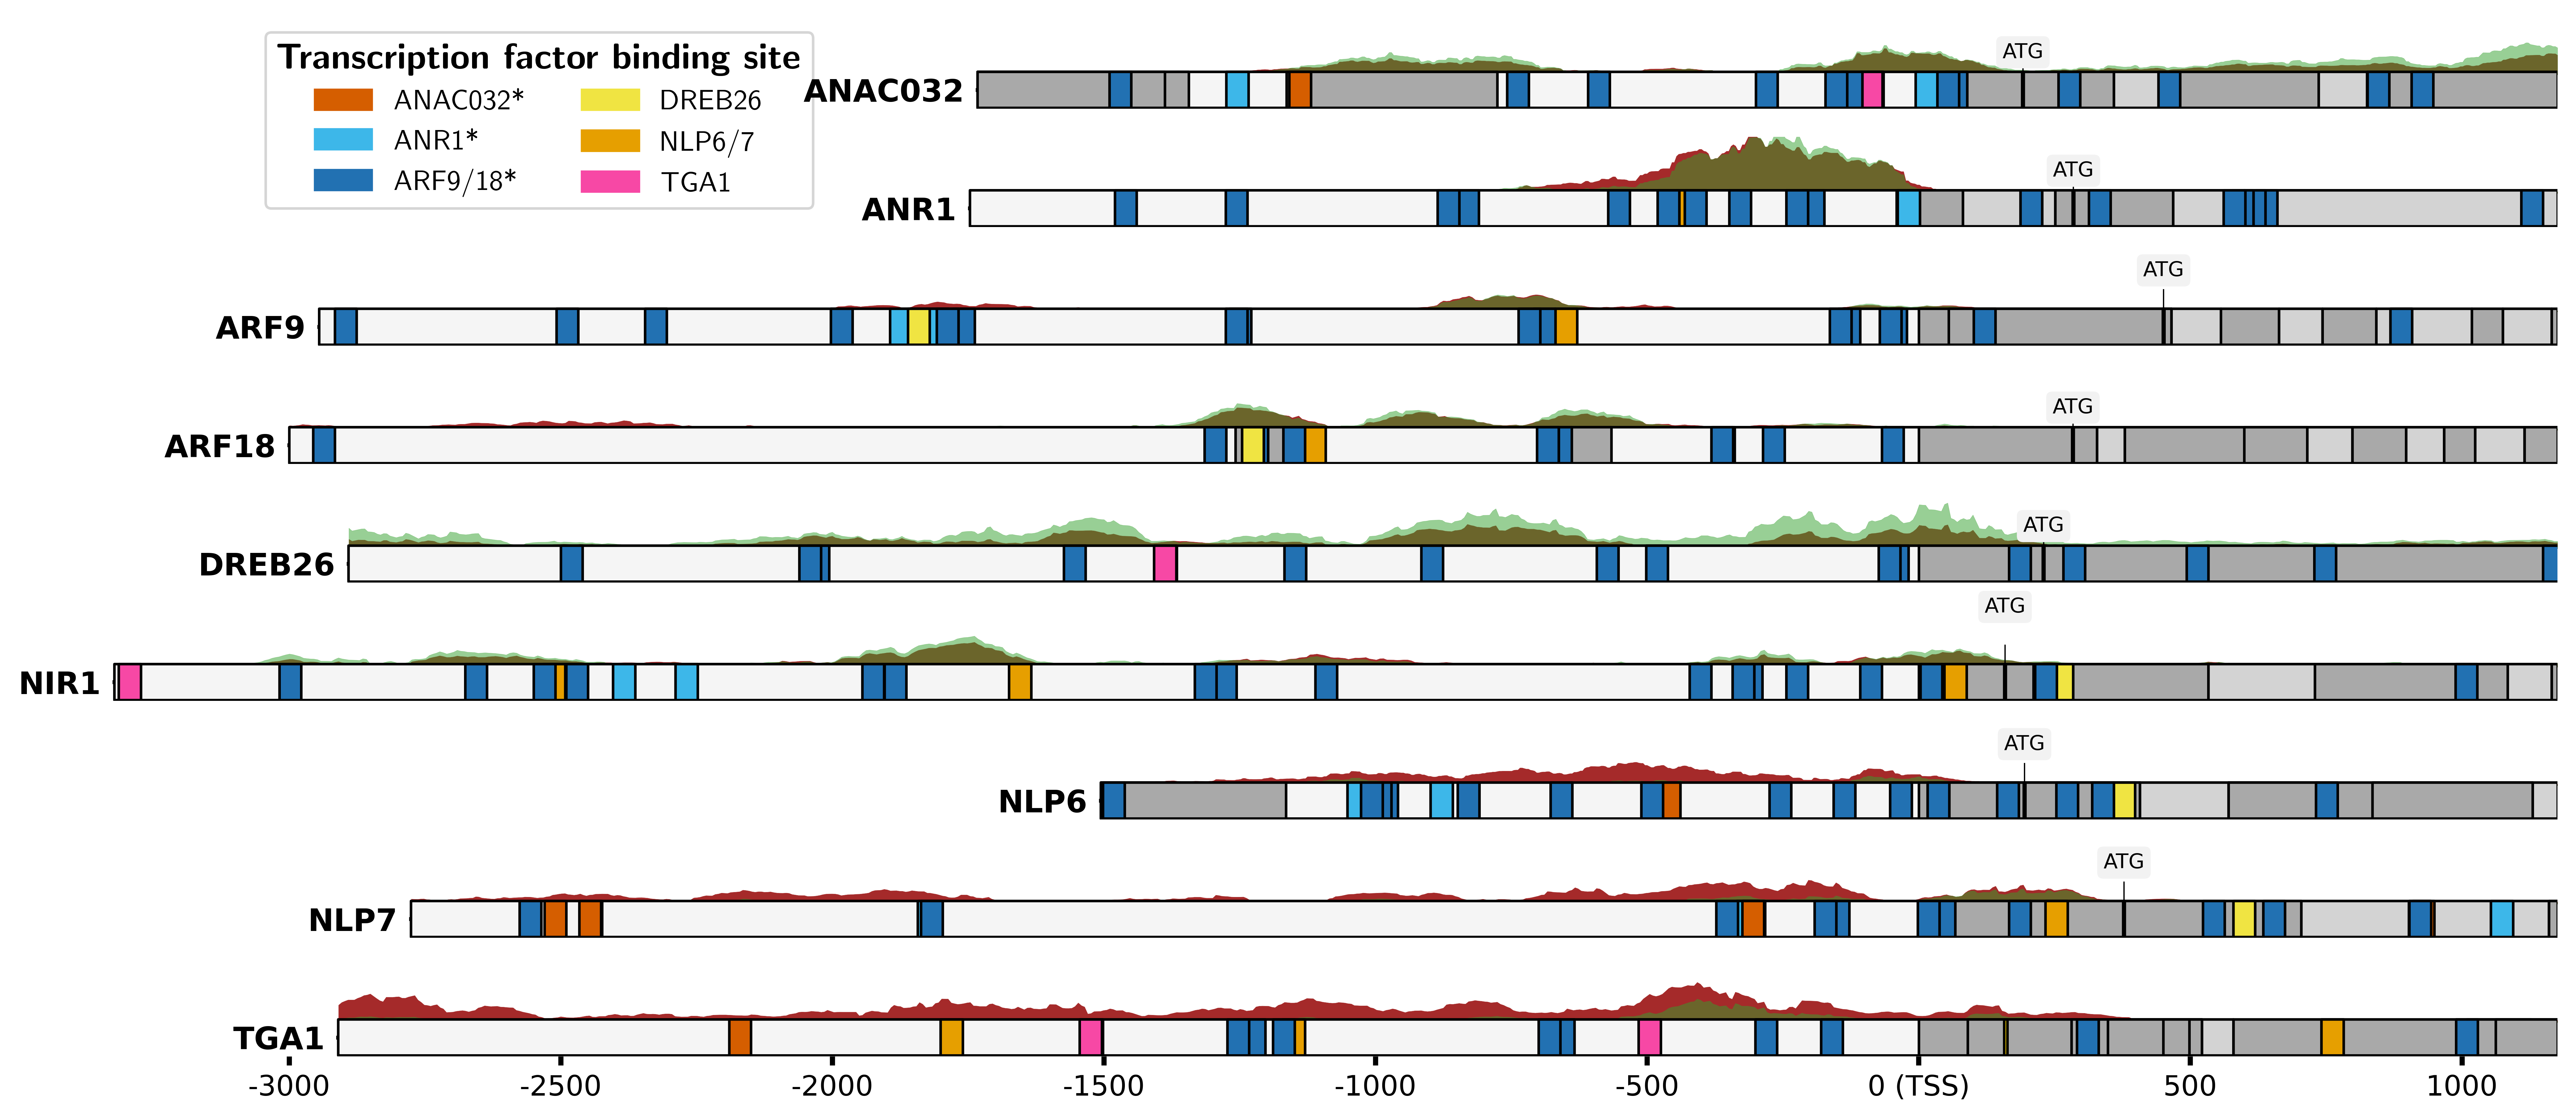

In [89]:
if __name__ == "__main__":
    import sys

    main(sys.argv[1:])